In [363]:
import numpy as np
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7,7)

(-10.0, 10.0)

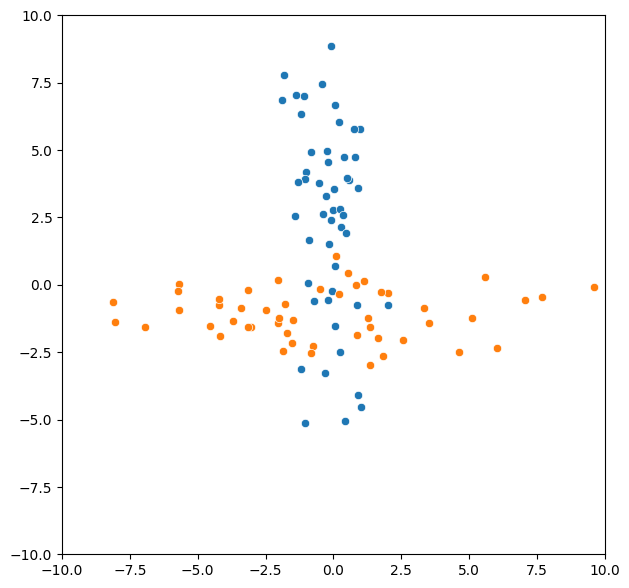

In [364]:
rng = np.random.default_rng(4329)
group1 = rng.normal((0,2),(1,4),size = (50,2))
group2 = rng.normal((0,-1),(4,1),size = (50,2))
data = np.concatenate((group1,group2),axis=0)
sns.scatterplot(x = group1[:,0], y = group1[:,1]) #g1
sns.scatterplot(x = group2[:,0], y = group2[:,1]) #g1
plt.xlim(-10,10)
plt.ylim(-10,10)

In [365]:
g1, g2 = rng.uniform((-5,0),(5,5),size = (2,2,2))
pi1, pi2 = 0.5,0.5
f = lambda x,y,gauss : norm.pdf(x,gauss[0,0],gauss[0,1]) * norm.pdf(y,gauss[1,0],gauss[1,1])
g1,g2

(array([[-4.46474149,  3.71846055],
        [ 3.48034871,  3.13617693]]),
 array([[ 0.65037215,  0.98149284],
        [-2.852008  ,  2.58028385]]))

(-10.0, 10.0)

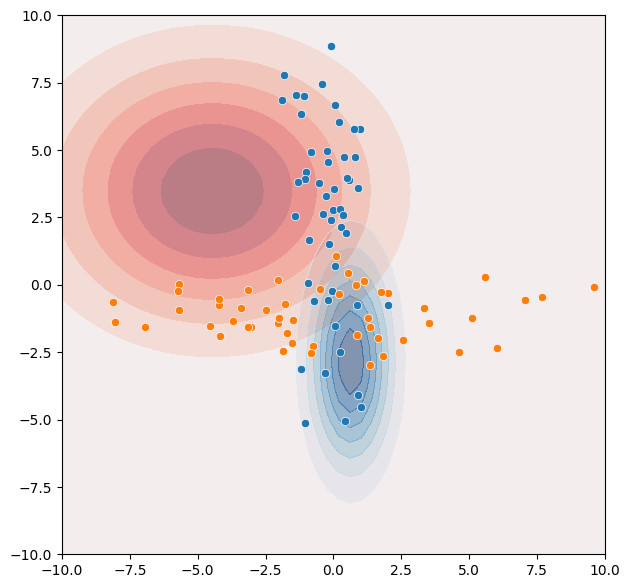

In [366]:
x_lin = np.linspace(-10,10)
xx, yy = np.meshgrid(x_lin,x_lin)
plt.contourf(xx,yy,f(xx,yy,g1),cmap="Reds")
plt.contourf(xx,yy,f(xx,yy,g2),alpha=0.5,cmap="Blues")
sns.scatterplot(x = group1[:,0], y = group1[:,1]) #g1
sns.scatterplot(x = group2[:,0], y = group2[:,1]) #g1
plt.xlim(-10,10)
plt.ylim(-10,10)

17


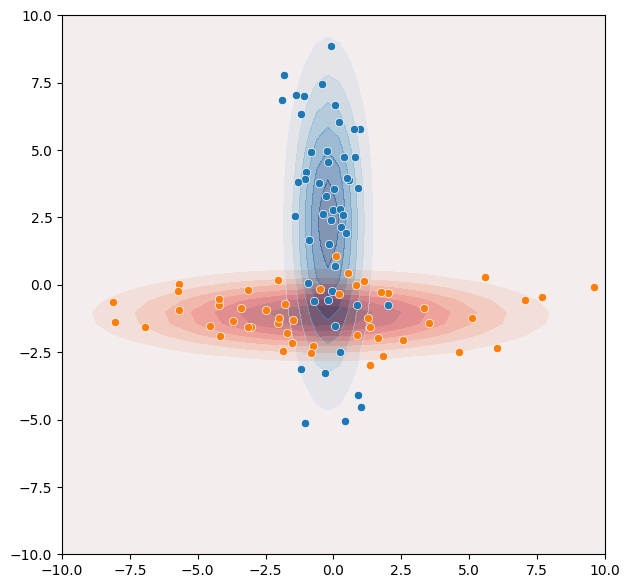

In [367]:
def ratios(data,g1, g2, pi1, pi2):
    p1 = pi1*f(data[:,0],data[:,1],g1)
    p2 = pi2*f(data[:,0],data[:,1],g2)
    ratio = p1/(p1+p2)
    return np.stack((ratio, 1-ratio), axis=1)


def exp_mean_std(data, ratio):
    m = (data*ratio).sum(axis=0) / ratio.sum()
    std =  np.sqrt(((data - m)**2 * ratio).sum(axis=0) / ratio.sum())
    return np.stack((m,std), axis=1)

for i in range(10000):
    prev_g1 = g1.copy()
    prev_g2 = g2.copy()
    r = ratios(data,g1, g2, pi1, pi2)
    pi1 = r[:,0].mean()
    pi2 = r[:,1].mean()
    g1 = exp_mean_std(data,r[:,0:1])
    g2 = exp_mean_std(data,r[:,1:2])
    if np.abs(prev_g1-g1).sum() + np.abs(prev_g2-g2).sum() < 0.01:
        break


plt.contourf(xx,yy,f(xx,yy,g1),cmap="Reds")
plt.contourf(xx,yy,f(xx,yy,g2),alpha=0.5,cmap="Blues")
sns.scatterplot(x = group1[:,0], y = group1[:,1]) #g1
sns.scatterplot(x = group2[:,0], y = group2[:,1]) #g1
plt.xlim(-10,10)
plt.ylim(-10,10)
print(i)

In [342]:
g1 , g2

(array([[-0.46412997,  4.15386055],
        [-1.12729169,  0.81586811]]),
 array([[-0.18746441,  0.84045344],
        [ 2.26076357,  3.55408091]]))